In [237]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from scipy.stats import norm
from sklearn.metrics import r2_score

In [238]:
# Laste poll-of-polls data
df = pd.read_csv("../data/pollofpolls_april.csv", sep=";")

In [239]:
#df = df[2:]

In [240]:
df

,Mnd,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
0,April-25,28.1,19.8,20.0,6.3,6.7,3.3,3.9,3.1,4.8,3.9
1,Mars-25,28.1,18.8,22.7,7.2,4.9,3.1,4.3,2.7,4.6,3.4
2,Februar-25,24.8,18.4,24.6,7.4,6.6,3.0,4.2,2.4,5.4,3.2
3,Januar-25,19.1,22.2,24.1,8.0,5.9,3.4,4.5,3.3,5.6,3.9
4,Desember-24,17.2,21.2,25.4,9.4,5.3,3.9,5.3,3.1,5.8,3.5
...,...,...,...,...,...,...,...,...,...,...,...
203,Mai-08,28.9,17.8,25.9,6.7,5.7,6.2,6.2,0.0,1.4,0.0
204,April-08,29.0,16.9,25.4,6.5,5.5,7.0,6.8,0.0,1.2,0.0
205,Mars-08,28.7,18.1,25.2,7.0,5.6,6.1,6.3,0.0,1.1,0.0
206,Februar-08,29.0,17.3,25.2,6.7,5.9,6.3,6.6,0.0,1.3,0.0


In [241]:
# tom dict for prediksjoner
predictions = {"Mnd": ["Mai-25","Juni-25","Juli-25","August-25","September-25"]}

In [242]:
###for å kunne konvertere til dato datatype
month_mapping = {
    "Januar": "January", "Februar": "February", "Mars": "March", "April": "April",
    "Mai": "May", "Juni": "June", "Juli": "July", "August": "August",
    "September": "September", "Oktober": "October", "November": "November", "Desember": "December"
}

# Replace Norwegian months with English
df["Mnd"] = df["Mnd"].replace(month_mapping, regex=True)

In [243]:
# Convert to datetime and set the date to the end of the month
df["Mnd"] = pd.to_datetime(df["Mnd"], format="%B-%y").dt.to_period("M").dt.to_timestamp("M")

# Sort values and set index
df = df.sort_values("Mnd")
df.set_index("Mnd", inplace=True)

In [244]:
df

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
Mnd,,,,,,,,,,
2008-01-31,29.3,17.2,23.9,7.4,6.1,6.4,6.5,0.0,1.3,0.0
2008-02-29,29.0,17.3,25.2,6.7,5.9,6.3,6.6,0.0,1.3,0.0
2008-03-31,28.7,18.1,25.2,7.0,5.6,6.1,6.3,0.0,1.1,0.0
2008-04-30,29.0,16.9,25.4,6.5,5.5,7.0,6.8,0.0,1.2,0.0
2008-05-31,28.9,17.8,25.9,6.7,5.7,6.2,6.2,0.0,1.4,0.0
...,...,...,...,...,...,...,...,...,...,...
2024-12-31,17.2,21.2,25.4,9.4,5.3,3.9,5.3,3.1,5.8,3.5
2025-01-31,19.1,22.2,24.1,8.0,5.9,3.4,4.5,3.3,5.6,3.9
2025-02-28,24.8,18.4,24.6,7.4,6.6,3.0,4.2,2.4,5.4,3.2


In [245]:
# Perform ADF test on each party's time series
for party in ['Ap', 'Hoyre', 'Frp', 'SV', 'Sp', 'KrF', 'Venstre', 'MDG','Rodt', 'Andre']: 
    result = adfuller(df[party])
    print(f"{party} ADF Statistic: {result[0]}, p-value: {result[1]}")
    if result[1] > 0.05:
        print(f"Warning: {party} is not stationary, consider differencing.")

Ap ADF Statistic: -1.856091209101095, p-value: 0.35299053505635986
Hoyre ADF Statistic: -2.3743352332276917, p-value: 0.14911149279892622
Frp ADF Statistic: -1.9477804761534157, p-value: 0.3099280070237853
SV ADF Statistic: -1.4434899546491162, p-value: 0.5612581829268658
Sp ADF Statistic: -1.6439254868948312, p-value: 0.46021035633648494
KrF ADF Statistic: -1.8640571185788328, p-value: 0.34915400542042474
Venstre ADF Statistic: -2.856245077970463, p-value: 0.05067782268037513
MDG ADF Statistic: -1.6150073726267, p-value: 0.47534769215062433
Rodt ADF Statistic: -0.8089746205993122, p-value: 0.8164716154484275
Andre ADF Statistic: -1.6263298279720702, p-value: 0.4694124047367569


In [246]:
df_diff = df.diff().dropna()  # Difference to make stationary

In [247]:
df_diff

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
Mnd,,,,,,,,,,
2008-02-29,-0.3,0.1,1.3,-0.7,-0.2,-0.1,0.1,0.0,0.0,0.0
2008-03-31,-0.3,0.8,0.0,0.3,-0.3,-0.2,-0.3,0.0,-0.2,0.0
2008-04-30,0.3,-1.2,0.2,-0.5,-0.1,0.9,0.5,0.0,0.1,0.0
2008-05-31,-0.1,0.9,0.5,0.2,0.2,-0.8,-0.6,0.0,0.2,0.0
2008-06-30,-2.9,-0.2,3.0,0.2,-0.4,-0.1,-0.3,0.0,0.4,0.0
...,...,...,...,...,...,...,...,...,...,...
2024-12-31,-1.5,-1.2,3.4,0.4,-1.3,0.8,0.2,-0.3,-0.1,-0.3
2025-01-31,1.9,1.0,-1.3,-1.4,0.6,-0.5,-0.8,0.2,-0.2,0.4
2025-02-28,5.7,-3.8,0.5,-0.6,0.7,-0.4,-0.3,-0.9,-0.2,-0.7


In [248]:
# ADF test on each column of df_diff
for col in df_diff.columns:
    result = adfuller(df_diff[col])
    print(f'{col}: p-value={result[1]}')

Ap: p-value=1.8231547731754667e-26
Hoyre: p-value=3.260372641692989e-12
Frp: p-value=1.8552224544108022e-24
SV: p-value=6.442869983127415e-30
Sp: p-value=1.9618051057752974e-28
KrF: p-value=2.559452905677872e-25
Venstre: p-value=6.023513946531267e-26
MDG: p-value=4.133228933063153e-29
Rodt: p-value=2.0937591147619804e-13
Andre: p-value=1.0383179066425754e-29


In [249]:
model = VAR(df_diff)  
model_fitted = model.fit(maxlags=5,method = 'ols', trend='n', verbose=True)

# Display the summary of the fitted model
print(model_fitted.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 07, May, 2025
Time:                     08:49:17
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                   -4.10946
Nobs:                     202.000    HQIC:                  -8.98504
Log likelihood:          -1124.13    FPE:                5.06454e-06
AIC:                     -12.2982    Det(Omega_mle):     5.54687e-07
--------------------------------------------------------------------
Results for equation Ap
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
L1.Ap             -1.390926         0.443506           -3.136           0.002
L1.Hoyre          -1.436729         0.443650           -3.238           0.001
L1.Frp            -1.416945         0.446112           -3.176           0.0

C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


In [250]:
# Compute R² for each party
r2_scores = {}
for party in df_diff.columns:
    r2_scores[party] = r2_score(df_diff[party].iloc[model_fitted.k_ar:], model_fitted.fittedvalues[party])

# Print R² values
for party, r2 in r2_scores.items():
    print(f"R² for {party}: {r2:.4f}")

R² for Ap: 0.2979
R² for Hoyre: 0.2573
R² for Frp: 0.2383
R² for SV: 0.3506
R² for Sp: 0.2290
R² for KrF: 0.4758
R² for Venstre: 0.3293
R² for MDG: 0.2932
R² for Rodt: 0.3684
R² for Andre: 0.3438


In [251]:
# Compute MAE, MSE, RMSE, and MAPE for each party
mae_scores = {}
mse_scores = {}
rmse_scores = {}

for party in df_diff.columns:
    actual = df_diff[party].iloc[model_fitted.k_ar:]
    predicted = model_fitted.fittedvalues[party]
    
    mae_scores[party] = mean_absolute_error(actual, predicted)
    mse_scores[party] = mean_squared_error(actual, predicted)
    rmse_scores[party] = np.sqrt(mse_scores[party])  # RMSE

# Print MAE, MSE, RMSE, and MAPE values
for party in df_diff.columns:
    print(f"MAE for {party}: {mae_scores[party]:.4f}")
    print(f"MSE for {party}: {mse_scores[party]:.4f}")
    print(f"RMSE for {party}: {rmse_scores[party]:.4f}")


MAE for Ap: 0.9292
MSE for Ap: 1.5461
RMSE for Ap: 1.2434
MAE for Hoyre: 0.8464
MSE for Hoyre: 1.1932
RMSE for Hoyre: 1.0923
MAE for Frp: 0.8087
MSE for Frp: 1.0427
RMSE for Frp: 1.0211
MAE for SV: 0.2850
MSE for SV: 0.1392
RMSE for SV: 0.3731
MAE for Sp: 0.5495
MSE for Sp: 0.6297
RMSE for Sp: 0.7935
MAE for KrF: 0.2090
MSE for KrF: 0.0804
RMSE for KrF: 0.2836
MAE for Venstre: 0.2835
MSE for Venstre: 0.1262
RMSE for Venstre: 0.3552
MAE for MDG: 0.2172
MSE for MDG: 0.0850
RMSE for MDG: 0.2915
MAE for Rodt: 0.2827
MSE for Rodt: 0.1414
RMSE for Rodt: 0.3760
MAE for Andre: 0.2402
MSE for Andre: 0.1030
RMSE for Andre: 0.3210


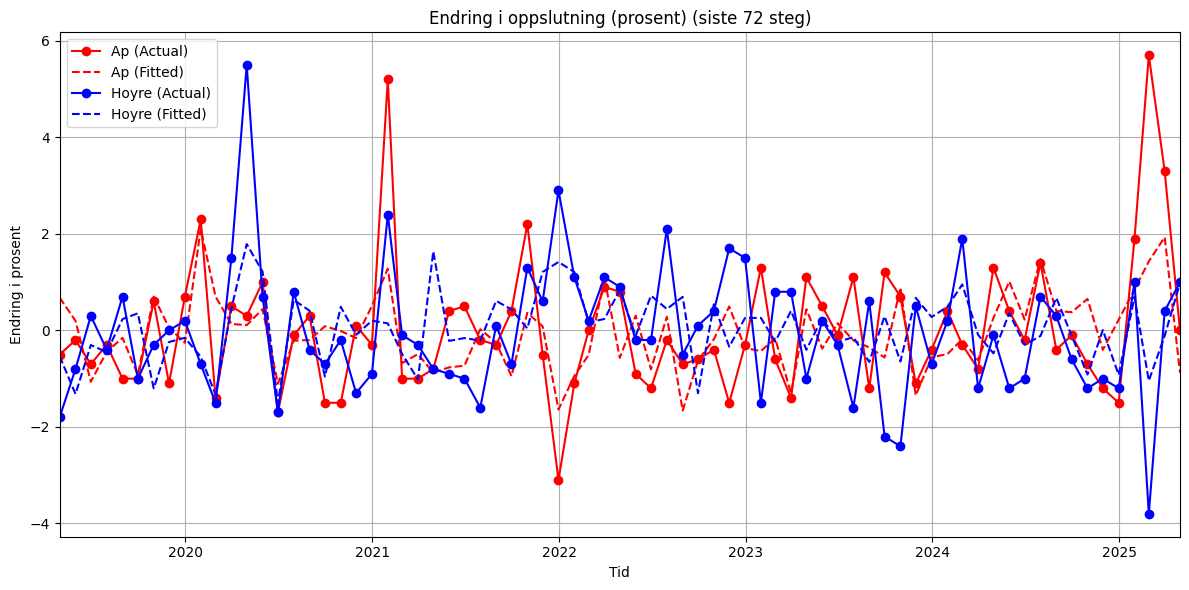

In [252]:
# Define a color map for consistency
colors = {
    'Ap': '#FF0000',        # Red
    'Hoyre': '#0000FF',     # Blue
}

# Number of time steps to plot back in time
steps = 73

# Get fitted values (predicted changes in differenced scale)
fitted_values = model_fitted.fittedvalues[-steps:]

# Create a figure for plotting
plt.figure(figsize=(12, 6))

for party in colors.keys():  # Iterate over defined parties
    color = colors[party]

    # Extract actual data for the last 'steps' data points
    actual_data = df_diff[party].iloc[-steps:]
    
    # Plot actual data (last 'steps' points)
    plt.plot(df_diff.index[-steps:], actual_data, marker="o", color=color, label=f"{party} (Actual)")

    # Plot fitted values (dashed line)
    plt.plot(fitted_values.index, fitted_values[party], linestyle="dashed", color=color, label=f"{party} (Fitted)")

    # Calculate the R-squared value between actual and fitted values
    r2 = r2_score(actual_data, fitted_values[party])

    # Print the R-squared value on the plot
    #plt.text(0.9, 0.1, f"R²: {r2:.4f}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom')

plt.xlim(df.index[-steps], df.index[-1])  # Set x-axis range to last 'steps' records
plt.xlabel("Tid")
plt.ylabel("Endring i prosent")
plt.title("Endring i oppslutning (prosent) (siste 72 steg)")

# Show the legend
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [253]:
# Check if the VAR model is stable (roots inside the unit circle)
print("Is the VAR model stable?", model_fitted.is_stable())

Is the VAR model stable? True


In [254]:
steps = 5  # Number of steps to forecast
alpha = 0.50

forecast, lower, upper = model_fitted.forecast_interval(df_diff.values[-model_fitted.k_ar:], steps=steps, alpha=alpha)

# Convert forecasted values to DataFrames
forecast_dates = pd.date_range(start="2025-05-31", periods=steps, freq='ME')

forecast_diff_df = pd.DataFrame(forecast, index=forecast_dates, columns=df.columns)
forecast_lower_diff_df = pd.DataFrame(lower, index=forecast_dates, columns=df.columns)
forecast_upper_diff_df = pd.DataFrame(upper, index=forecast_dates, columns=df.columns)

# Convert predictions back to original scale
last_actual_value = df.iloc[-1]  # Last known actual data point

forecast_original_scale = forecast_diff_df.cumsum() + last_actual_value
forecast_lower_original_scale = forecast_lower_diff_df.cumsum() + last_actual_value
forecast_upper_original_scale = forecast_upper_diff_df.cumsum() + last_actual_value


In [255]:
# Get forecast covariance in differenced scale
forecast_cov_diff = model_fitted.forecast_cov(steps=steps)

# Initialize original scale covariance matrix
forecast_cov_original_scale = np.zeros_like(forecast_cov_diff)

# Cumulative sum of covariance matrices to restore original scale
for t in range(steps):
    forecast_cov_original_scale[t] = np.sum(forecast_cov_diff[:t+1], axis=0)

# Convert to DataFrames for readability
forecast_cov_original_df = {t: pd.DataFrame(forecast_cov_original_scale[t], index=df.columns, columns=df.columns)
                            for t in range(steps)}


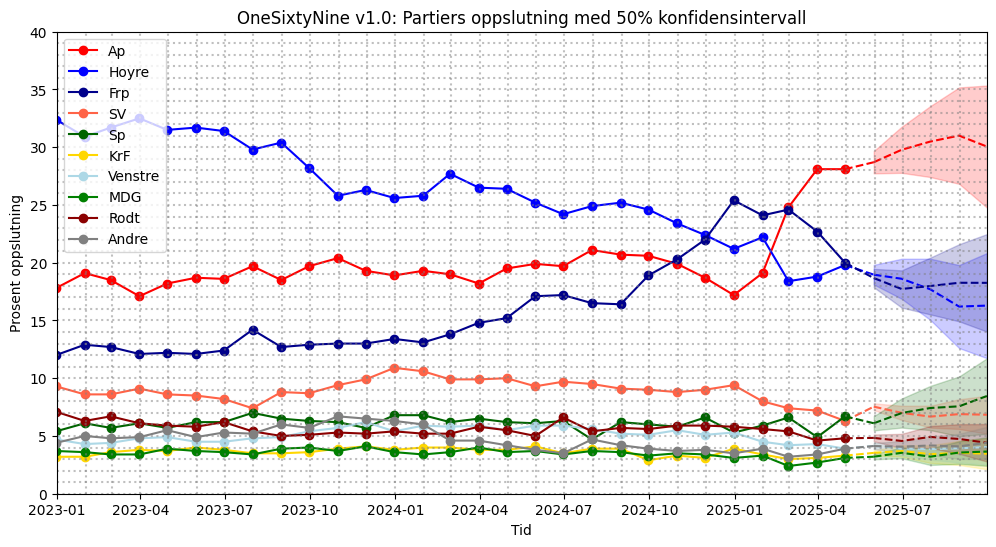

In [256]:
# Define a color map for consistency
colors = {
    'Ap': '#FF0000',        # Red
    'Hoyre': '#0000FF',     # Blue
    'Frp': '#00008B',       # Dark Blue
    'SV': '#FF6347',        # Light Red (Tomato)
    'Sp': '#006400',        # Dark Green
    'KrF': '#FFD700',       # Yellow (Gold)
    'Venstre': '#ADD8E6',   # Light Blue
    'MDG': '#008000',       # Green
    'Rodt': '#8B0000',      # Dark Red
    'Andre': '#808080'      # Gray
}

plt.figure(figsize=(12, 6))

for party in colors.keys():  # Iterate over defined parties
    color = colors[party]  

    # Plot actual data
    plt.plot(df.index, df[party], marker="o", color=color, label=f"{party}")

    # Plot forecast (original scale)
    plt.plot(forecast_original_scale.index, forecast_original_scale[party], linestyle="dashed", color=color)

    last_actual_date = df.index[-1]
    first_forecast_date = forecast_original_scale.index[0]
    last_actual_value = df[party].iloc[-1]
    first_forecast_value = forecast_original_scale[party].iloc[0]

    plt.plot([last_actual_date, first_forecast_date], [last_actual_value, first_forecast_value], color=color, linestyle="dashed")
    
    # Plot confidence interval (original scale)
    plt.fill_between(forecast_original_scale.index, 
                     forecast_lower_original_scale[party], 
                     forecast_upper_original_scale[party], 
                     color=color, alpha=0.2)


dates = pd.date_range(start="2023-01-01", end="2025-09-30", freq="MS")  # "MS" = Month Start
for date in dates:
    plt.axvline(date, color="gray", linestyle="dotted", alpha=0.5)

# Add horizontal grid lines every 5%
for percent in range(0, 45, 1):
    plt.axhline(percent, color="gray", linestyle="dotted", alpha=0.5)

plt.xlim(np.datetime64("2023-01-01"), np.datetime64("2025-09-30"))  # Manually set max date to Sept 2025
plt.ylim(0,40)  # Manually set max date to Sept 2025
plt.xlabel("Tid")
plt.ylabel("Prosent oppslutning")
plt.title("OneSixtyNine v1.0: Partiers oppslutning med 50% konfidensintervall")
plt.legend(loc="upper left")
plt.show()

In [257]:
forecast_original_scale

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
2025-05-31,28.702116,18.966141,18.672589,7.538023,6.101246,3.535553,4.139860,3.206534,4.833549,4.129193
2025-06-30,29.776645,18.611889,17.727955,7.001656,6.984860,3.697677,3.908709,3.542488,4.569999,4.073779
2025-07-31,30.491185,17.696327,17.984738,6.675631,7.422618,3.426410,3.864168,3.207508,4.916412,4.178456
2025-08-31,31.005856,16.205443,18.264514,6.892511,7.567265,3.537837,3.930380,3.565556,4.741573,4.099381
2025-09-30,30.056639,16.287257,18.257453,6.837687,8.458863,3.461844,4.045523,3.650402,4.411482,4.407131


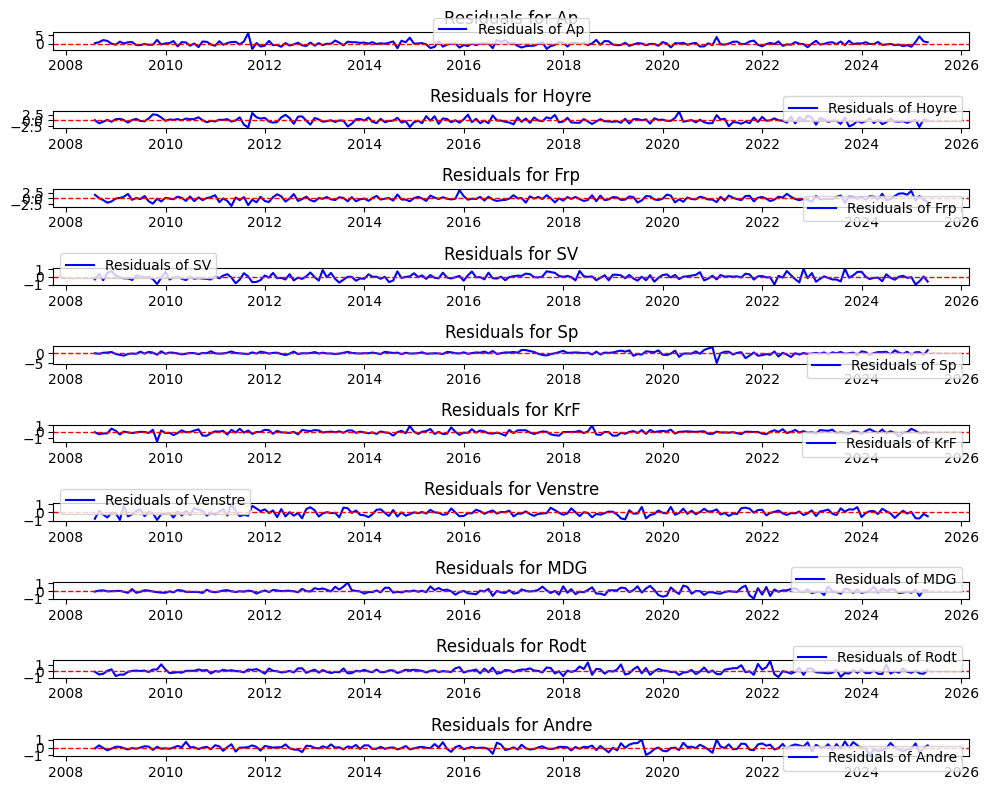

In [258]:
# Get residuals from the fitted model
residuals = model_fitted.resid  # Residuals for all variables

# Plot residuals for each variable
fig, axes = plt.subplots(nrows=residuals.shape[1], ncols=1, figsize=(10, 8))

for i, col in enumerate(residuals.columns):
    axes[i].plot(residuals.index, residuals[col], label=f"Residuals of {col}", color="blue")
    axes[i].axhline(y=0, linestyle="--", color="red", linewidth=1)
    axes[i].set_title(f"Residuals for {col}")
    axes[i].legend()

plt.tight_layout()
plt.show()

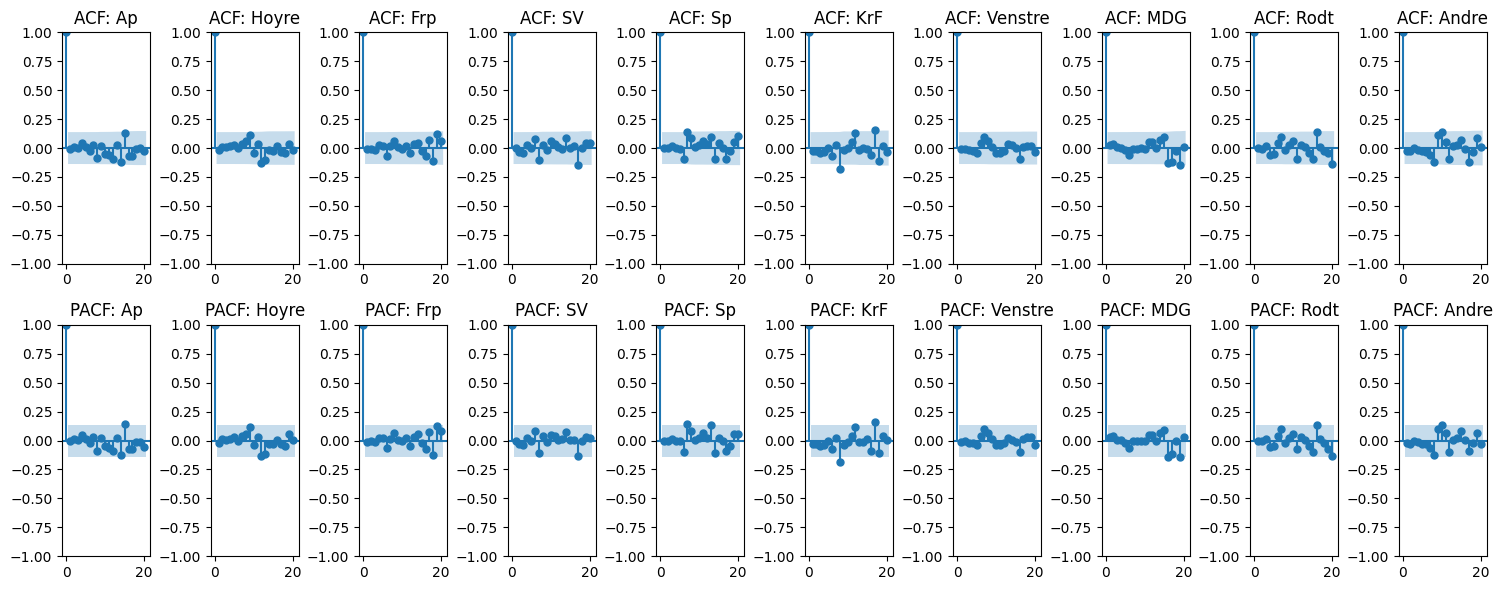

In [259]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF & PACF for residuals of the first variable
fig, axes = plt.subplots(nrows=2, ncols=residuals.shape[1], figsize=(15, 6))

for i, col in enumerate(residuals.columns):
    plot_acf(residuals[col], ax=axes[0, i], lags=20, title=f"ACF: {col}")
    plot_pacf(residuals[col], ax=axes[1, i], lags=20, title=f"PACF: {col}")

plt.tight_layout()
plt.show()

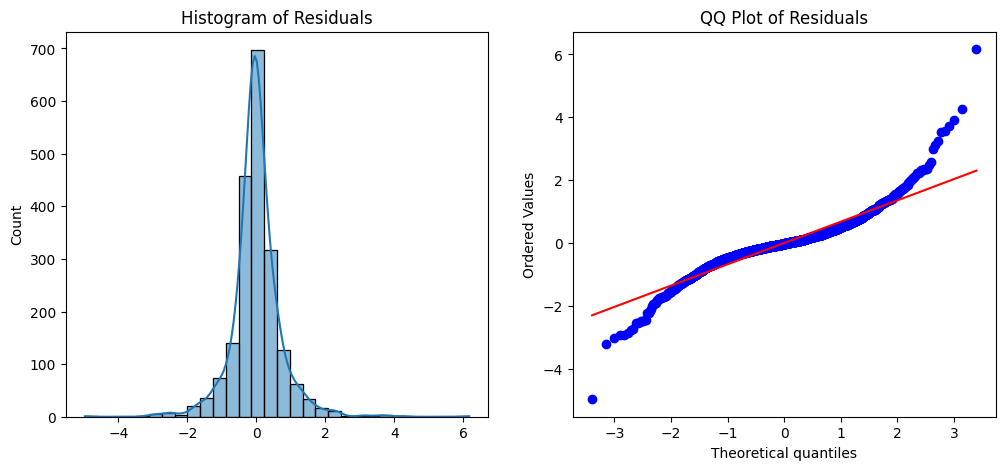

In [260]:
import scipy.stats as stats

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Histogram of residuals
sns.histplot(residuals.values.flatten(), kde=True, ax=axes[0], bins=30)
axes[0].set_title("Histogram of Residuals")

# QQ Plot
stats.probplot(residuals.values.flatten(), dist="norm", plot=axes[1])
axes[1].set_title("QQ Plot of Residuals")

plt.show()


In [261]:
forecast_lower_original_scale

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
2025-05-31,27.735292,18.116807,17.878627,7.247933,5.484229,3.315018,3.863678,2.979885,4.541198,3.879627
2025-06-30,27.783293,16.878265,16.117503,6.388753,5.726004,3.210429,3.321702,3.077034,3.956012,3.554019
2025-07-31,27.417923,15.044287,15.523932,5.729000,5.509065,2.664567,2.959804,2.488424,3.970989,3.380646
2025-08-31,26.833869,12.613278,14.928162,5.606554,4.980803,2.488234,2.705287,2.589893,3.462776,3.008864
2025-09-30,24.774097,11.737818,14.035585,5.198346,5.190007,2.120994,2.494140,2.413265,2.789074,3.018479


In [262]:
forecast_upper_original_scale

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
2025-05-31,29.668940,19.815475,19.466550,7.828113,6.718263,3.756088,4.416043,3.433183,5.125900,4.378759
2025-06-30,31.769996,20.345514,19.338408,7.614560,8.243716,4.184925,4.495715,4.007941,5.183985,4.593540
2025-07-31,33.564447,20.348368,20.445544,7.622263,9.336171,4.188252,4.768531,3.926592,5.861835,4.976266
2025-08-31,35.177843,19.797608,21.600866,8.178468,10.153728,4.587440,5.155473,4.541219,6.020371,5.189899
2025-09-30,35.339181,20.836697,22.479322,8.477028,11.727718,4.802693,5.596907,4.887539,6.033889,5.795782


In [263]:
###finn estimat for september
date_to_extract = "2025-09-30"

# Extract the row for the given date from each dataframe
estimate_row = forecast_original_scale.loc[date_to_extract]
lower_row = forecast_lower_original_scale.loc[date_to_extract]
upper_row = forecast_upper_original_scale.loc[date_to_extract]

# Combine into a new DataFrame
result_df = pd.DataFrame({
    "Party": estimate_row.index,
    "Estimate": estimate_row.values,
    "Lower": lower_row.values,
    "Upper": upper_row.values
})

# Display the final structured DataFrame
print(result_df)


     Party   Estimate      Lower      Upper
0       Ap  30.056639  24.774097  35.339181
1    Hoyre  16.287257  11.737818  20.836697
2      Frp  18.257453  14.035585  22.479322
3       SV   6.837687   5.198346   8.477028
4       Sp   8.458863   5.190007  11.727718
5      KrF   3.461844   2.120994   4.802693
6  Venstre   4.045523   2.494140   5.596907
7      MDG   3.650402   2.413265   4.887539
8     Rodt   4.411482   2.789074   6.033889
9    Andre   4.407131   3.018479   5.795782


In [264]:
forecast_original_scale

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
2025-05-31,28.702116,18.966141,18.672589,7.538023,6.101246,3.535553,4.139860,3.206534,4.833549,4.129193
2025-06-30,29.776645,18.611889,17.727955,7.001656,6.984860,3.697677,3.908709,3.542488,4.569999,4.073779
2025-07-31,30.491185,17.696327,17.984738,6.675631,7.422618,3.426410,3.864168,3.207508,4.916412,4.178456
2025-08-31,31.005856,16.205443,18.264514,6.892511,7.567265,3.537837,3.930380,3.565556,4.741573,4.099381
2025-09-30,30.056639,16.287257,18.257453,6.837687,8.458863,3.461844,4.045523,3.650402,4.411482,4.407131


In [265]:
# Multivariate MC!
n_sim = 1000000
# Extract mean estimates (yhat) and covariance matrix
yhat_vector = result_df["Estimate"].values  # Mean estimates for all parties
#yhat_vector = forecast_original_scale["Estimate"].values  # Mean estimates for all parties
cov_matrix = forecast_cov_original_scale[-1]  # Covariance matrix at final step (latest forecast)

# Generate correlated samples
samples = np.random.multivariate_normal(yhat_vector, cov_matrix, size=n_sim)
samples = np.maximum(samples, 1e-6) ##must be above 0
samples = (samples.T / samples.sum(axis=1) * 100).T

# Create a DataFrame with sampled values
sampled_df = pd.DataFrame(samples, columns=result_df["Party"])

# Compute vote totals for each simulation
red_green_votes = sampled_df[["Ap", "SV", "Sp", "Rodt", "MDG"]].sum(axis=1)/sampled_df.sum(axis=1)
blue_votes = sampled_df[["Hoyre", "Frp", "KrF", "Venstre"]].sum(axis=1)/sampled_df.sum(axis=1)

# Probability that red-green block wins
prob_red_green_wins = np.mean(red_green_votes > blue_votes)

print(f"Sannsyn for at Ap+SV+Sp+R+MDG > H+FrP+KrF+V: {prob_red_green_wins:.4f}")


Sannsyn for at Ap+SV+Sp+R+MDG > H+FrP+KrF+V: 0.9492


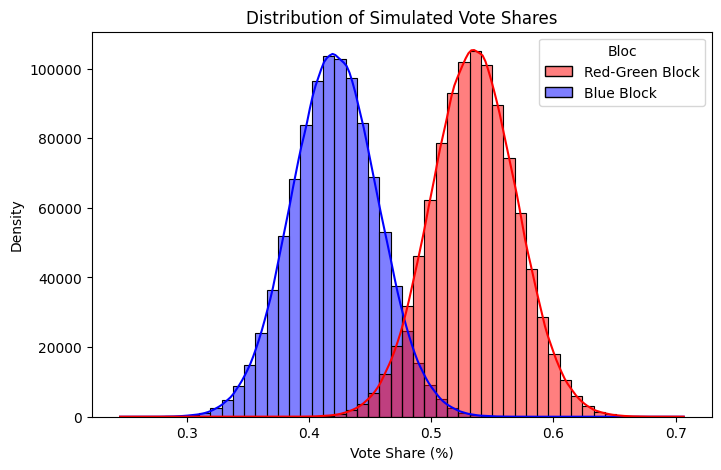

In [266]:
# Create a DataFrame with both red-green and blue votes
df_votes = pd.DataFrame({
    "Red-Green Block": red_green_votes,
    "Blue Block": blue_votes
})

# Melt the DataFrame for easier plotting
df_votes_melted = df_votes.melt(var_name="Bloc", value_name="Votes")

# Plot
plt.figure(figsize=(8, 5))
sns.histplot(data=df_votes_melted, x="Votes", hue="Bloc", kde=True, palette={"Red-Green Block": "red", "Blue Block": "blue"}, alpha=0.5, bins=50)
plt.xlabel("Vote Share (%)")
plt.ylabel("Density")
plt.title("Distribution of Simulated Vote Shares")
plt.show()


In [267]:
# Define party groupings
red_green_parties = ["Ap", "SV", "Sp", "Rodt", "MDG"]
blue_parties = ["Hoyre", "Frp", "KrF", "Venstre"]

# Calculate sum columns for each bloc
forecast_original_scale["Red-Green Block"] = forecast_original_scale[red_green_parties].sum(axis=1)
forecast_lower_original_scale["Red-Green Block"] = forecast_lower_original_scale[red_green_parties].sum(axis=1)
forecast_upper_original_scale["Red-Green Block"] = forecast_upper_original_scale[red_green_parties].sum(axis=1)

forecast_original_scale["Blue Block"] = forecast_original_scale[blue_parties].sum(axis=1)
forecast_lower_original_scale["Blue Block"] = forecast_lower_original_scale[blue_parties].sum(axis=1)
forecast_upper_original_scale["Blue Block"] = forecast_upper_original_scale[blue_parties].sum(axis=1)


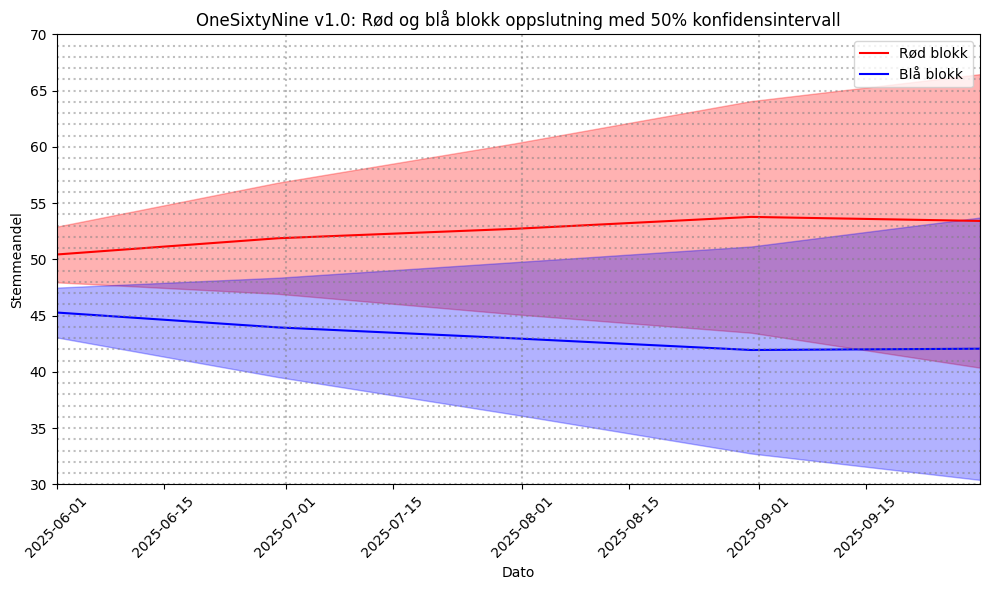

In [268]:
# Plot the red-green and blue block time series with confidence intervals
plt.figure(figsize=(10, 6))

# Plot Red-Green Block with confidence intervals
sns.lineplot(data=forecast_original_scale, x=forecast_original_scale.index, y="Red-Green Block", label="Rød blokk", color="red")
plt.fill_between(forecast_original_scale.index, 
                 forecast_lower_original_scale["Red-Green Block"], 
                 forecast_upper_original_scale["Red-Green Block"], 
                 color="red", alpha=0.3)

# Plot Blue Block with confidence intervals
sns.lineplot(data=forecast_original_scale, x=forecast_original_scale.index, y="Blue Block", label="Blå blokk", color="blue")
plt.fill_between(forecast_original_scale.index, 
                 forecast_lower_original_scale["Blue Block"], 
                 forecast_upper_original_scale["Blue Block"], 
                 color="blue", alpha=0.3)

dates = pd.date_range(start="2025-05-01", end="2025-09-30", freq="MS")  # "MS" = Month Start
for date in dates:
    plt.axvline(date, color="gray", linestyle="dotted", alpha=0.5)

# Add horizontal grid lines every 5%
for percent in range(30, 70, 1):
    plt.axhline(percent, color="gray", linestyle="dotted", alpha=0.5)

# Customize the plot
plt.xlim(np.datetime64("2025-06-01"), np.datetime64("2025-09-30"))  # Manually set max date to Sept 2025
plt.ylim(30,70)  # Manually set max date to Sept 2025
plt.title('OneSixtyNine v1.0: Rød og blå blokk oppslutning med 50% konfidensintervall')
plt.xlabel('Dato')
plt.ylabel('Stemmeandel')
plt.legend()
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()
